# C matrices from MGC and DCORR

neurodata/hyppo DCorr with c matrix [branch](https://github.com/neurodata/hyppo/blob/dcorr-c-mat/hyppo/independence/dcorr.py#L228).

neurodata/scipy MGC with c matrix (pending repo access)
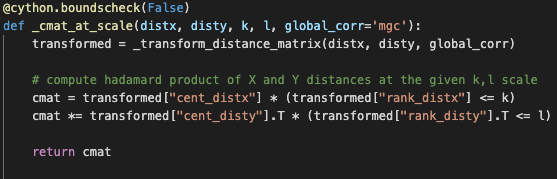

MGC calculations
1. Raw distance matrices $Dx, Dy$
2. $Dx,Dy$ column means subtracted and diagonals at 0 => $A,B$
3. $Dx,Dy$ column values ranked 1-n => $G,H$
4. Given k,l optimal scale: $G_{k} = (G \leq k)$, $H_l = (H \leq l)$ binary matrices
5. C matrix = $A \circ G_k \circ B^T \circ H_l^T$ 

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap

import sys; sys.path.append('../')
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

In [3]:
## Define paths
#base_dir = Path('/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/')
base_dir = Path('/mnt/ssd3/ronan/data/gcca_old_min_rank-ZG3/')## Define paths

In [4]:
groups, labels = get_latents(base_dir, flag='_gcca-zg')

## Experts vs. Novices

In [5]:
ways = [[0],[0],[0],[1],[1],[1]]
X,Y = k_sample_transform(groups, ways=ways)
X = X[:,:,:3].reshape(X.shape[0],-1)

In [6]:
X_dists = pairwise_distances(X, metric='euclidean')
Y_dists = pairwise_distances(Y, metric='sqeuclidean') / 2

DCorr C matrix

In [7]:
dc_stat, dc_pvalue, c_mat = Dcorr(compute_distance=None).test(X_dists, Y_dists, workers=-1, reps=1000, c_mat=True)
print(f'pvalue: {dc_pvalue}')

pvalue: 0.001


MGC C matrix

In [8]:
stat, pvalue, mgc_dict = multiscale_graphcorr(X_dists, Y_dists, workers=-1, reps=1000, compute_distance=None, compute_c_mat=True)
print(f'pvalue: {pvalue}')
print(f'opt_scale: {mgc_dict["opt_scale"]}')

pvalue: 0.001
opt_scale: [5, 2]


In [9]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
y_labels = [f'{a}' for a,b in y]

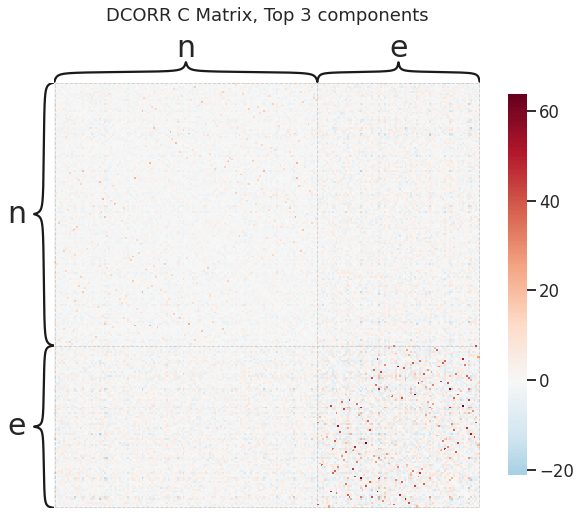

In [10]:
heatmap(c_mat, title=f'DCORR C Matrix, Top 3 components', transform=None, inner_hier_labels=y_labels)

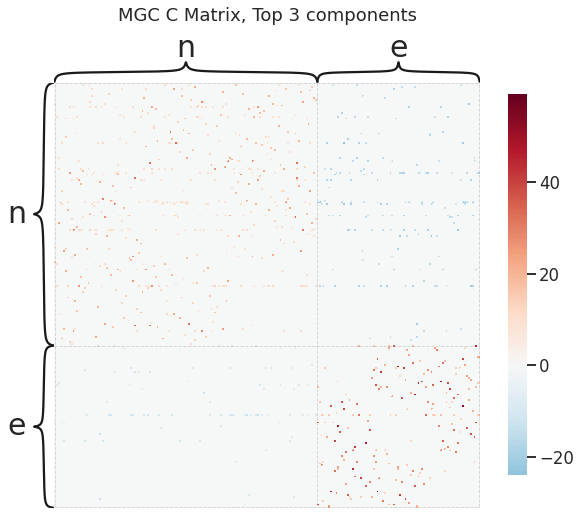

In [11]:
heatmap(mgc_dict['c_mat'], title=f'MGC C Matrix, Top 3 components', transform=None, inner_hier_labels=y_labels)

## 2-way (states and traits)

In [12]:
ways = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
X,Y = k_sample_transform(groups, ways=ways)
X = X[:,:,:3].reshape(X.shape[0],-1)

In [13]:
X_dists = pairwise_distances(X, metric='euclidean')
Y_dists = pairwise_distances(Y, metric='sqeuclidean') / 2

DCorr C matrix

In [14]:
dc_stat, dc_pvalue, c_mat = Dcorr(compute_distance=None).test(X_dists, Y_dists, workers=-1, reps=1000, c_mat=True)
print(f'pvalue: {dc_pvalue}')

pvalue: 0.001


MGC C matrix

In [15]:
stat, pvalue, mgc_dict = multiscale_graphcorr(X_dists, Y_dists, workers=-1, reps=1000, compute_distance=None, compute_c_mat=True)
print(f'pvalue: {pvalue}')
print(f'opt_scale: {mgc_dict["opt_scale"]}')

pvalue: 0.004
opt_scale: [207, 3]


In [16]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
y_labels = [f'{a} {b}' for a,b in y]

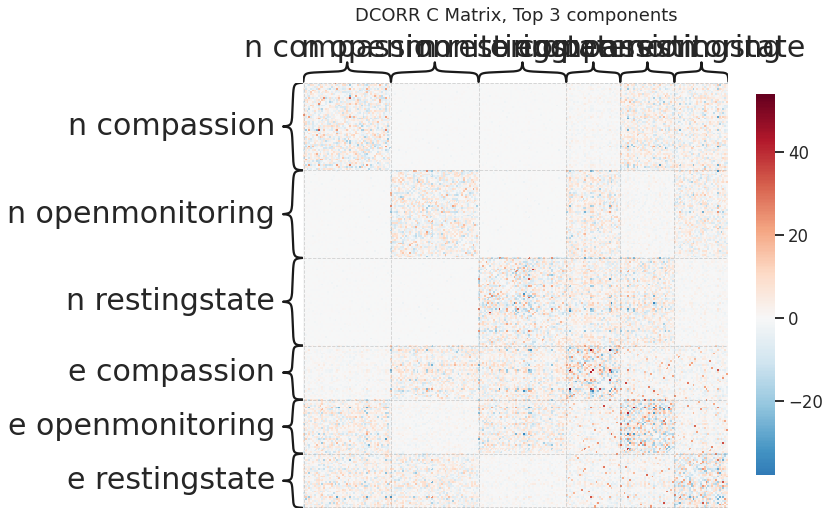

In [17]:
heatmap(c_mat, title=f'DCORR C Matrix, Top 3 components', transform=None, inner_hier_labels=y_labels)

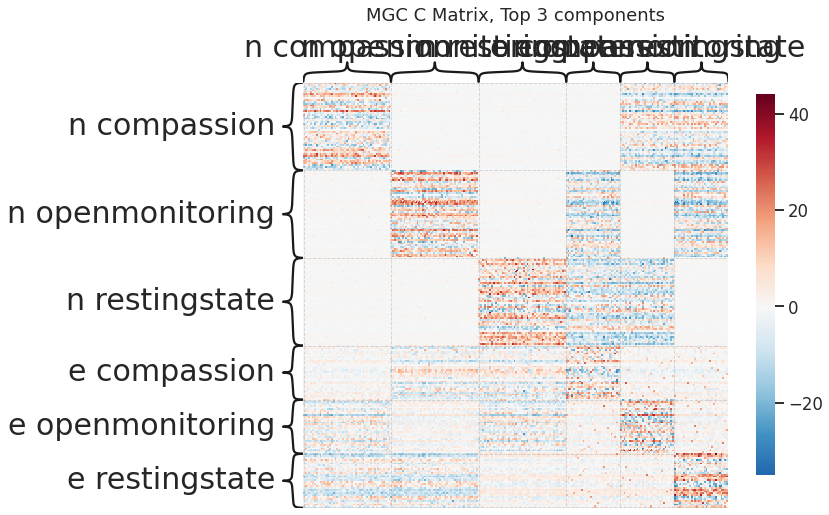

In [18]:
heatmap(mgc_dict['c_mat'], title=f'MGC C Matrix, Top 3 components', transform=None, inner_hier_labels=y_labels)

## Validation
modified code to yield the raw distance and rank matrices for validation purposes

In [7]:
stat, pvalue, mgc_dict = multiscale_graphcorr(X_dists, Y_dists, workers=-1, reps=1, compute_distance=None, compute_c_mat=True)

In [84]:
## What MGC runs
distx, disty, rank_distx, rank_disty = mgc_dict['c_mat']
disty = disty.T
rank_disty = rank_disty.T

rank_distx = np.asarray(rank_distx, np.int64) - 1
rank_disty = np.asarray(rank_disty, np.int64) - 1

n = distx.shape[0]
nx = np.max(rank_distx) + 1
ny = np.max(rank_disty) + 1
cov_xy = np.zeros((nx, ny))
expectx = np.zeros(nx)
expecty = np.zeros(ny)

for i in range(n):
    for j in range(n):
        a = distx[i, j]
        b = disty[i, j]
        k = rank_distx[i, j]
        l = rank_disty[i, j]

        cov_xy[k, l] += a * b

        expectx[k] += a
        expecty[l] += b
        
cov_xy[:, 0] = np.cumsum(cov_xy[:, 0])
expectx = np.cumsum(expectx)

cov_xy[0, :] = np.cumsum(cov_xy[0, :])
expecty = np.cumsum(expecty)

for k in range(nx - 1):
    for l in range(ny - 1):
        cov_xy[k+1, l+1] += (cov_xy[k+1, l] + cov_xy[k, l+1] - cov_xy[k, l])

pre centering and normalization (which effectively a scales of all values in the c matrix)

In [115]:
cov_xy

array([[    0.        ,     0.        ],
       [ 5335.51525167,  5204.44531777],
       [ 8733.34007263,  7989.69840998],
       [10181.77030187,  8013.23374279],
       [11657.5863608 ,  8275.26164729],
       [12923.23954448,  8243.56485524],
       [14062.06800981,  8050.30864155],
       [15368.25387401,  8265.47642427],
       [16476.59330922,  8144.88531964],
       [17553.53058189,  8020.30702903],
       [18662.06201647,  8006.07301075],
       [19833.82104496,  8169.02462759],
       [20958.4483887 ,  8283.16000125],
       [22040.11064059,  8357.82174939],
       [23091.9952689 ,  8413.07991137],
       [24140.63848416,  8494.00253035],
       [25056.57280278,  8342.78732673],
       [26100.77643397,  8480.59409601],
       [27025.81441767,  8412.76415772],
       [27896.0590216 ,  8263.36417071],
       [28844.52260015,  8295.05297081],
       [29841.32882757,  8449.09495604],
       [30752.19586591,  8459.13271615],
       [31618.44187772,  8406.18691316],
       [32463.46

In [123]:
distx, disty, rank_distx, rank_disty = mgc_dict['c_mat']

In [125]:
## C matrix calculation for each k,l

c_mats = np.zeros((np.max(rank_distx), np.max(rank_disty)))
for k in range(1,np.max(rank_distx)+1):
    for l in range(1,np.max(rank_disty)+1):
        c_mats[k-1][l-1] = np.sum(distx * disty.T * (rank_distx <= k) * (rank_disty.T<=l))

In [126]:
print(f'max error: {np.max(np.abs(c_mats - cov_xy))}')

max error: 5.820766091346741e-11
